<a href="https://colab.research.google.com/github/ppokranguser/Artificial_Intelligence_study/blob/main/K_means_GMM_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs, make_moons

parser = argparse.ArgumentParser(description='AI course, CAU')
parser.add_argument('--data_type', type=int, default=0, help='0: Gaussian data, 1: Moon-shaped data')
parser.add_argument('--cluster_method', type=int, default=0, help='0: k-Means, 1: GMM, 2: DBSCAN')
parser.add_argument('--cluster_num', type=int, default=3, help='The number of clusters')
parser.add_argument('--eps', type=int, default=0.5, help='The epsilon for DBSCAN')
parser.add_argument('--min_pts', type=int, default=5, help='The minimum number of data points')

args = parser.parse_args(['--data_type', '0', '--cluster_method', '0', '--cluster_num', '5'])


In [75]:
def generate_data(type):
    if type == 0:
        # Sampling 100 data points for each cluster
        sample_sizes = [100, 100, 100]

        # The mean of each clusters are µ1 = [7.0, −1.0], µ2 = [3.0, −1.5], µ3 = [5.5, 1.0]
        means = [[7.0, -1.0], [3.0, -1.5], [5.5, 1.0]]

        # Standard deviation is same for all clusters σ = 0.7
        stds = [0.7, 0.7, 0.7]

        # Data type 1: double moon shaped data
        X, y = make_blobs(n_samples = sample_sizes, centers = means, n_features = 2, cluster_std = stds, random_state=0)
        print (X)

        # visualize the generated data
        plt.scatter(X[:, 0], X[:, 1], s=50, cmap='Paired')
        plt.show()

        return X, y

    else:
        # Data type 2: double moon shaped data
        X, y = make_moons(200, noise=.05, random_state=0)
        print (X)

        # visualize the generated data
        plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='Paired')
        plt.show()

        return X, y

In [76]:
import numpy as np

def kmeans(X, max_iterations, k):
    # 데이터 포인트의 개수와 차원
    num_samples, num_features = X.shape  # (200, 2)

    # 데이터의 범위를 기준으로 랜덤하게 k개의 초기 중심점(centroids)을 생성
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    centroids = np.array([[np.random.uniform(x_min, x_max), np.random.uniform(y_min, y_max)] for _ in range(k)])

    # 멤버십 초기화
    memberships = np.zeros(num_samples)

    for _ in range(max_iterations):
        # 각 데이터 포인트에 대해 가장 가까운 중심점을 찾아 멤버십 할당
        for i in range(num_samples):
            min_distance = float('inf')  # 초기 최소 거리를 무한대로 설정
            assigned_cluster = -1  # 초기 할당 클러스터

            # 각 중심점과의 거리를 계산하여 가장 가까운 중심점 할당
            for j in range(k):
                distance = np.sqrt(np.sum((X[i] - centroids[j]) ** 2))  # 유클리디안 거리 계산
                if distance < min_distance:
                    min_distance = distance
                    assigned_cluster = j  # 가장 가까운 클러스터로 할당

            memberships[i] = assigned_cluster  # 데이터 포인트 i에 클러스터 j 할당

        # 할당된 클러스터에 따라 데이터 포인트들을 평균내어 새로운 centorids로 업데이트
        for j in range(k):
            points_in_cluster = X[memberships == j]
            if len(points_in_cluster) > 0:
                centroids[j] = np.mean(points_in_cluster, axis=0)
            # 비어있는 클러스터의 경우 기존 중심을 그대로 유지

    return centroids, memberships


In [77]:

"""초기 평균, 공분산, 혼합 계수를 설정합니다."""
def initialize_parameters(X, k):
    num_samples, num_features = X.shape
    # 데이터의 범위를 기준으로 랜덤하게 k개의 초기 평균을 생성
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    means = np.array([[np.random.uniform(x_min, x_max), np.random.uniform(y_min, y_max)] for _ in range(k)])
    # 초기 공분산은 단위 행렬로 설정
    covariances = [np.eye(num_features) for _ in range(k)]
    # 초기 혼합 계수는 동일하게 설정
    weights = np.ones(k) / k

    return means, covariances, weights

""" 가우시안 확률 밀도 함수(PDF)를 계산합니다."""
def gaussian_pdf(X, mean, cov):
    num_features = X.shape[1]
    cov_det = np.linalg.det(cov)
    cov_inv = np.linalg.inv(cov)

    norm_const = 1.0 / (np.power((2 * np.pi), num_features / 2) * np.sqrt(cov_det))
    X_mean = X - mean
    result = np.exp(-0.5 * np.sum(X_mean @ cov_inv * X_mean, axis=1))

    return norm_const * result

"""GMM 알고리즘을 구현합니다."""
def gmm(X, max_iterations, k):
    num_samples, num_features = X.shape

    # 1. 초기화 단계
    means, covariances, weights = initialize_parameters(X, k)

    # 책임도 초기화
    responsibilities = np.zeros((num_samples, k))

    for iteration in range(max_iterations):
        # 2. E-Step: 각 데이터 포인트가 각 클러스터에 속할 확률(책임도) 계산
        for j in range(k):
            pdf = gaussian_pdf(X, means[j], covariances[j])
            responsibilities[:, j] = weights[j] * pdf

        # 각 데이터 포인트에 대한 책임도 합계로 정규화
        responsibilities_sum = responsibilities.sum(axis=1, keepdims=True)
        responsibilities /= responsibilities_sum

        # 3. M-Step: 각 클러스터의 파라미터 업데이트
        for j in range(k):
            # 책임도 합계 계산
            responsibility = responsibilities[:, j]
            total_responsibility = responsibility.sum()

            # 평균 업데이트
            means[j] = (X * responsibility[:, np.newaxis]).sum(axis=0) / total_responsibility

            # 공분산 업데이트
            X_mean = X - means[j]
            covariances[j] = (responsibility[:, np.newaxis] * X_mean).T @ X_mean / total_responsibility

            # 혼합 계수 업데이트
            weights[j] = total_responsibility / num_samples

    # 최종 클러스터 할당
    memberships = np.argmax(responsibilities, axis=1)

    return means, memberships


In [78]:
def dbscan(X, eps, min_pts):
    # 데이터 포인트 개수
    num_samples = X.shape[0]

    # 포인트 상태를 추적하는 배열 초기화 (0: 미방문, 1이상: 클러스터 ID, -1: 노이즈)
    memberships = [0] * num_samples  # 모든 포인트는 처음에 미방문 상태

    cluster_id = 0  # 초기 클러스터 ID 설정

    for point_idx in range(num_samples):
        # 이미 방문한 포인트는 무시
        if memberships[point_idx] != 0:
            continue

        # 현재 포인트의 이웃 찾기
        neighbors = []
        for i in range(num_samples):
            distance = np.sqrt(np.sum((X[point_idx] - X[i])**2))
            if distance <= eps:
                neighbors.append(i)

        # 핵심 점이 아닌 경우 노이즈로 간주
        if len(neighbors) < min_pts:
            memberships[point_idx] = -1
        else:
            # 새로운 클러스터 형성
            cluster_id += 1
            memberships[point_idx] = cluster_id

            # 클러스터 확장 (반복적으로 이웃을 탐색하며 추가)
            i = 0
            while i < len(neighbors):
                neighbor_idx = neighbors[i]

                # 이웃이 아직 미방문인 경우
                if memberships[neighbor_idx] == 0:
                    memberships[neighbor_idx] = cluster_id  # 현재 클러스터로 할당

                    # 이웃 포인트의 이웃들 찾기
                    new_neighbors = []
                    for j in range(num_samples):
                        distance = np.sqrt(np.sum((X[neighbor_idx] - X[j])**2))
                        if distance <= eps:
                            new_neighbors.append(j)

                    # 이웃 포인트가 핵심 점이라면, 해당 이웃들을 추가
                    if len(new_neighbors) >= min_pts:
                        neighbors.extend(new_neighbors)

                # 노이즈로 표시된 포인트라면 클러스터에 포함
                elif memberships[neighbor_idx] == -1:
                    memberships[neighbor_idx] = cluster_id

                i += 1

    return memberships

[[ 7.66506189e+00 -1.10595005e+00]
 [ 4.36913862e+00 -1.22693467e+00]
 [ 2.75259778e+00 -2.63153193e+00]
 [ 6.68112725e+00 -9.87764589e-01]
 [ 7.32596371e+00 -2.07537058e+00]
 [ 3.10955458e+00 -1.33747327e+00]
 [ 6.42339581e+00  3.82306827e-01]
 [ 4.56745184e+00 -3.78037283e-01]
 [ 2.61999697e+00 -1.20876497e+00]
 [ 7.47060633e+00 -7.14776715e-01]
 [ 6.15972768e+00  8.12683678e-01]
 [ 6.92774680e+00 -7.12581049e-01]
 [ 6.51380250e+00 -1.10474418e+00]
 [ 3.93227716e+00  1.28104934e+00]
 [ 7.36629366e+00 -1.12008243e+00]
 [ 5.33058612e+00  2.06278282e+00]
 [ 5.13773667e+00  3.14819098e-01]
 [ 5.10148156e+00  1.18893305e+00]
 [ 5.22333971e+00  1.88405639e-01]
 [ 4.82022680e+00  1.22037204e+00]
 [ 7.53272641e+00 -9.14827488e-01]
 [ 6.19677194e+00 -1.30647403e+00]
 [ 6.64324347e+00 -1.30665201e+00]
 [ 6.69539251e+00  2.94484610e-01]
 [ 5.17320812e+00  8.16572081e-03]
 [ 6.75646150e+00 -8.90555722e-01]
 [ 5.75957750e+00  1.09944326e+00]
 [ 2.78369092e+00 -2.67320266e+00]
 [ 6.06039536e+00  1

<ipython-input-75-50afb7b70cd7>:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], s=50, cmap='Paired')


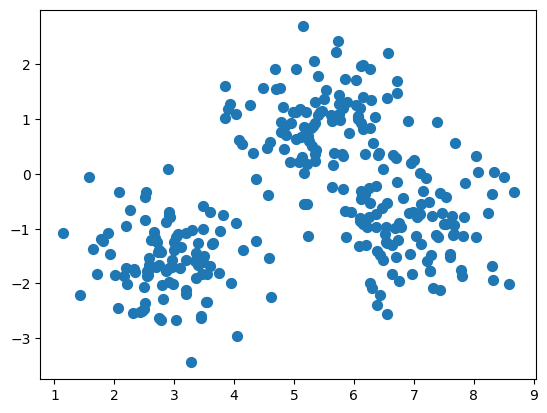

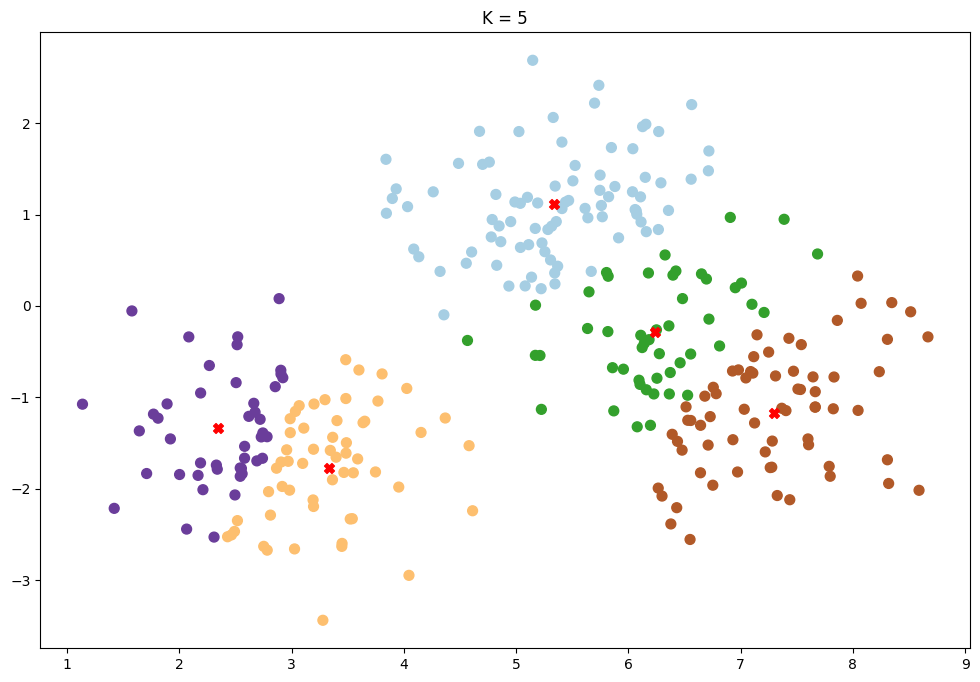

In [79]:
if __name__ == "__main__":
    X, y = generate_data(args.data_type)

    if args.cluster_method == 0:
        centroids_kmeans, memberships_kmeans = kmeans(X, 100, args.cluster_num)

    elif args.cluster_method == 1:
        centroids_kmeans, memberships_kmeans = gmm(X, 100, args.cluster_num)

    elif args.cluster_method == 2:
        memberships_kmeans = dbscan(X, args.eps, args.min_pts)

    else:
        pass

    # for visualization
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title("K = " + str(args.cluster_num))
    ax.scatter(X[:, 0], X[:, 1], c=memberships_kmeans, s=50, cmap='Paired')

    ## plotting centroids
    if args.cluster_method == 0 or 1:
        ax.scatter(centroids_kmeans[:, 0], centroids_kmeans[:, 1], color='red', s=50, marker="X");
    plt.show()